In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import special
from skimage import util, draw, io, filters, color, exposure, transform, feature, segmentation, measure, morphology, draw, transform, filters, img_as_float, img_as_ubyte
import opensimplex

# Perlin noise approach

In [ ]:
N = 100
l = np.zeros(N)
a = np.linspace(0,2*np.pi,N)
r = np.random.random(N)

x = r * np.cos(a)
y = r * np.sin(a)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_aspect('equal')
ax.plot(x,y)
ax.grid()





In [ ]:
N = 100
A = np.zeros((N,N))
gamma = 1
for i in range(10):
    z = np.random.rand()*N*1.5
    x = np.linspace(z,z+i,N)
    y = x
    a = opensimplex.noise2array(x, y)*np.exp(-i*gamma)
    A += a

A /= np.abs(A).max()
from matplotlib import cm
plt.imshow(A, cmap=cm.jet)

c = N//2
a = np.linspace(0,2*np.pi,N*2)
r = N//2-2

x = (r * np.cos(a) + c).astype(int)
y = (r * np.sin(a) + c).astype(int)

plt.colorbar()
plt.scatter(x, y, c='r')
plt.show()

l = A[x, y]
L = np.ones_like(l)*2
L += l
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
ax.plot(a, L)


In [ ]:
mask = np.zeros((100,100))
c = mask.shape[0]//2

i = (L*10 * np.cos(a) + c).astype(int)
j = (L*10 * np.sin(a) + c).astype(int)

mask[i,j] = 1
plt.figure(figsize=(10,10))
plt.imshow(mask)

## Refactor

In [ ]:
class NoiseBlob:
    def __init__(self, size):
        self.size = size

        self.mask = None
        self.texture = None

    def make_mask(self, gamma, circularity):
        contour, angular_span = self.generate_contour(gamma, circularity)
        self.mask = self.generate_blob(contour, angular_span).astype(bool)
        return self.mask

    def make_texture(self, gamma):
        if type(self.mask) == None: raise RuntimeError('Mask is not generated')
        self.texture = np.zeros(self.mask.shape)
        noise = self.generate_noise(self.mask.shape, gamma)
        noise -= noise.min()
        noise /= noise.max()
        self.texture[self.mask] = noise[self.mask]
        return self.texture

    def fill_contours(self, arr):
        return np.maximum.accumulate(arr, 1) * \
            np.maximum.accumulate(arr[:, ::-1], 1)[:, ::-1] * \
            np.maximum.accumulate(arr[::-1, :], 0)[::-1, :] * \
            np.maximum.accumulate(arr, 0)

    def generate_blob(self, contour, angular_span):
        # Generate a mask
        i = np.rint(contour * self.size * np.cos(angular_span)).astype(int)
        j = np.rint(contour * self.size * np.sin(angular_span)).astype(int)

        i -= i.min()
        j -= j.min()
        # i += 1
        # j += 1

        h = i.max() + 1
        w = j.max() + 1

        mask = np.zeros([h,w])
        mask[i,j] = 1
        mask = self.fill_contours(mask)
        self.mask = mask

        return mask

    def generate_noise(self, shape, gamma):
        N = max(shape)
        A = np.zeros(shape)
        # np.random.seed(5)
        for i in range(50):
            z = np.random.rand()*N*1.5
            x = np.linspace(z, z + i, shape[1])
            y = np.linspace(z, z + i, shape[0])
            a = opensimplex.noise2array(x, y)*np.exp(-i*gamma)
            A += a

        A /= np.abs(A).max()
        return A

    def generate_contour(self, gamma, circularity):
        # Creating a noise domain
        N = 100
        A = self.generate_noise((N,N), gamma)

        # Sampling from noise domain
        c = N//2
        a = np.linspace(0,2*np.pi,N*10)
        r = N//2-1

        x = np.rint(r * np.cos(a) + c).astype(int)
        y = np.rint(r * np.sin(a) + c).astype(int)

        noise_patch = A[x, y]

        # Adding noise to circle contour with weight circularity
        contour = np.ones_like(noise_patch) * circularity
        contour += noise_patch
        contour /= contour.mean()
        return contour, a

# gamma = np.linspace(0,1,5)
# circularity = np.linspace(1,3,5)
gamma = np.linspace(0.7,0.7,5)
circularity = np.linspace(2,2,5)

blobs = np.zeros((25,60,60))
for i, g in enumerate(gamma):
    for j, c in enumerate(circularity):
        blob = NoiseBlob(size=10)
        mask = blob.make_mask(gamma = g, circularity = c)
        mask = blob.make_texture(.1)
        mask = np.pad(mask, 10, 'constant', constant_values=0)
        mask = transform.resize(mask, (60,60), anti_aliasing=False)
        mask -= mask.min()
        mask /= mask.max()
        mask *= 255
        blobs[i*5 + j] = mask

m = util.montage(blobs).astype(np.uint8)
    # io.imsave(f'blobs{gamma}.png', m)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(m, cmap='gray', extent=(0,5,5,0))

ax.set_xticks(np.arange(0,5)+0.5)
ax.set_xticklabels(circularity)
ax.set_xlabel('circularity $c$')

ax.set_yticks(np.arange(0,5)+0.5)
ax.set_yticklabels(gamma)
ax.set_ylabel('gamma $\gamma$')


fig.savefig('gamma circularity shape generation.png')
plt.show()

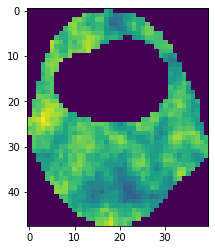

In [3]:
class Cell:
    """Class for generating a cell

    Raises:
        RuntimeError: When there is no way to position a nucleus within the
        cytoplasm

    Returns:
        Cell: self
    """
    # gamma_nucleus = 1.5
    # circ_nucleus = 2.5
    # gamma_cytoplasm = 1
    # circ_cytoplasm = 2
    # gamma_cytoplasm_texture = 1

    def __init__(self,  cytoplasm_size,
                        nucleus_size,
                        gamma_nucleus,
                        circ_nucleus,
                        gamma_cytoplasm,
                        circ_cytoplasm,
                        gamma_cytoplasm_texture,
                        lowest_intensity
                        ):
        """Cell generator, based on opensimplex noise generation

        Args:
            cytoplasm_size (int): radius of cytoplasm in pixels
            nucleus_size (int): radius of nucleus in pixels
            gamma_nucleus (float): noise parameter, defines the shape of nucleus. Typical values are between 0.5 and 1.5
            circ_nucleus (float): circularity of cytoplasm. Defines the shape of cytoplasm. Typical values are between 1 and 2
            gamma_cytoplasm (float): noise parameter, defines the shape of cytoplasm. Typical values are between 0.1 and 1.5
            circ_cytoplasm (float): circularity of cytoplasm. Defines the shape of cytoplasm. Typical values are between 1 and 3
            gamma_cytoplasm_texture (float): noise parameter, defines the frequency of cytoplasm texture. Typical values are between 0.01 and 2
        """
        self.size_cytoplasm = cytoplasm_size
        self.nucleus_size = nucleus_size

        self.gamma_nucleus = gamma_nucleus
        self.circ_nucleus = circ_nucleus
        self.gamma_cytoplasm = gamma_cytoplasm
        self.circ_cytoplasm = circ_cytoplasm
        self.gamma_cytoplasm_texture = gamma_cytoplasm_texture
        self.lowest_intensity = lowest_intensity

        self.mask_cytoplasm = None
        self.mask_nucleus = None
        self.texture_cytoplasm = None
        self.image = None

    def _normalize(self, arr):
        arr -= arr.min()
        arr /= arr.max()
        return arr

    def _shift(self,image, vector):
        tr = transform.AffineTransform(translation=vector)
        shifted = transform.warp(image, tr, preserve_range=True)
        shifted = shifted.astype(image.dtype)
        return shifted

    def run(self):
        self.generate_cytoplasm()
        self.generate_nucleus()
        self.position_nucleus()
        self.apply_texture()
        
    def generate_nucleus(self):
        NB = NoiseBlob(size=self.nucleus_size)
        self.mask_nucleus = NB.make_mask(self.gamma_nucleus, self.circ_nucleus)

    def generate_cytoplasm(self):
        NB = NoiseBlob(size=self.size_cytoplasm)
        self.mask_cytoplasm = NB.make_mask(self.gamma_cytoplasm, self.circ_cytoplasm)
        self.texture_cytoplasm = NB.make_texture(self.gamma_cytoplasm_texture)

    def position_nucleus(self):
        hc, wc = self.mask_cytoplasm.shape
        hn, wn = self.mask_nucleus.shape

        mask_nucleus = np.pad(self.mask_nucleus, ((0,hc-hn), (0,wc-wn)), 'constant', constant_values=0)

        terminator = 0
        while terminator <= 100:
            x = np.random.randint(0, wc-wn)
            y = np.random.randint(0, hc-hn)

            shifted = self._shift(mask_nucleus, (-y, -x))
            if np.all(self.mask_cytoplasm[shifted]):
                break
            else:
                terminator += 1
                if terminator == 100:
                    raise RuntimeError('Could not position nucleus, try to decrease nucleus size or increase cytoplasm size')

        self.mask_cytoplasm[shifted] = 0

    def apply_texture(self):
        self.image = np.zeros_like(self.texture_cytoplasm)
        self.image[self.mask_cytoplasm] = self.texture_cytoplasm[self.mask_cytoplasm] + self.lowest_intensity
        self.image = self._normalize(self.image)

c = Cell(   cytoplasm_size          = 20,
            nucleus_size            = 10,
            gamma_nucleus           = 1.5,
            circ_nucleus            = 2.5,
            gamma_cytoplasm         = 1.0,
            circ_cytoplasm          = 2.0,
            gamma_cytoplasm_texture = .05,
            lowest_intensity        = 0.4)
c.run()

fig, ax = plt.subplots(1,1)
ax.imshow(c.image)
        

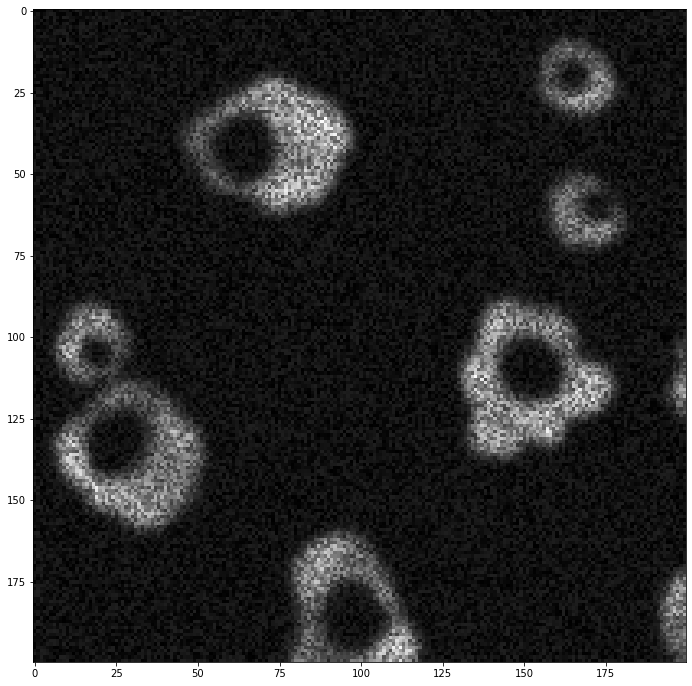

In [16]:
class Simulator:

    def __init__(self, shape, cell_number) -> None:
        self.image = np.zeros(shape)
        self.mask  = np.zeros(shape)
        self.shape = shape
        self.cell_number = cell_number
        self.sigma = 2
        self.noise_signal_level = 0.5
        self.noise_background_level = 0.2

        self.C1 = Cell(  
            cytoplasm_size          = 20,
            nucleus_size            = 10,
            gamma_nucleus           = 1.5,
            circ_nucleus            = 2,
            gamma_cytoplasm         = 0.5,
            circ_cytoplasm          = 2.0,
            gamma_cytoplasm_texture = .5,
            lowest_intensity        = 0.5)

        self.C2 = Cell(  
            cytoplasm_size          = 10,
            nucleus_size            = 5,
            gamma_nucleus           = 1.5,
            circ_nucleus            = 2.5,
            gamma_cytoplasm         = 1.0,
            circ_cytoplasm          = 2.0,
            gamma_cytoplasm_texture = .5,
            lowest_intensity        = 0.5)

    def normalize(func):
        def wrapper(self, *args, **kwargs):
            func(self, *args, **kwargs)
            self.image -= self.image.min()
            self.image /= self.image.max()
        return wrapper

    def run(self):
        self.populate()
        self.apply_filter()
        self.apply_noise()       
        return self.image

    def _expand(self, arr):
        h, w = self.shape
        py = (0, h - arr.shape[0])
        px = (0, w - arr.shape[1])
        arr = np.copy(arr)
        arr = np.pad(arr, (py, px), 'constant', constant_values=0)
        return arr

    def _shift(self, image, vector):
        tr = transform.AffineTransform(translation=vector)
        shifted = transform.warp(image, tr, preserve_range=True)
        shifted = shifted.astype(image.dtype)
        return shifted

    def position_cell(self, cell, pos):
        mask = self._expand(cell.mask_cytoplasm)
        mask = self._shift(mask, pos)
        return mask
    
    @normalize
    def apply_filter(self):
        self.image = filters.gaussian(self.image, sigma=self.sigma)

    @normalize
    def apply_noise(self):
        self.image *= (np.random.random(self.shape)+self.noise_signal_level)
        self.image += np.random.random(self.shape)*self.noise_background_level

    @normalize
    def populate(self):
        for i in range(self.cell_number):
            C = np.random.choice([self.C1, self.C2])
            C.run()
            terminate = 0
            while True:
                y = np.random.randint(0, self.shape[0])
                x = np.random.randint(0, self.shape[1])
                mask = self.position_cell(C, (-y, -x))
                if np.any(self.mask[mask]):
                    terminate += 1
                else:
                    image = self._expand(C.image)
                    image = self._shift(image, (-y, -x))
                    self.mask += mask
                    self.image[mask] = image[mask]
                    break
                if terminate == 100:
                    raise RuntimeError('Could not position cell, try to decrease cell size or increase simulation size')

sim = Simulator(shape=(200,200), cell_number=10)
sim.run()
plt.figure(figsize=(12,12))

plt.imshow(sim.image, cmap='gray'); plt.show()

        
           

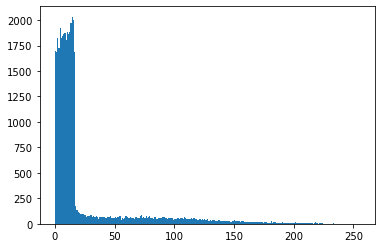

In [11]:
plt.hist(sim.image.flatten()*255, bins = np.arange(0,256));

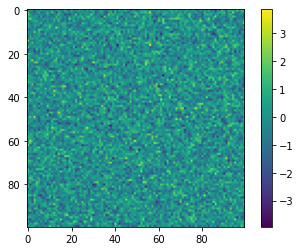

In [7]:
a= np.random.normal(0,1,(100,100))
plt.imshow(a)
plt.colorbar()